In [5]:
%pip install torch torchvision pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

# Assuming the xlsx file is named 'data.xlsx'
df = pd.read_excel('dataset/combined.xlsx', engine='openpyxl')

imgs_with_spacing = df[df['S'] == 1] # get all rows where the df['B'] is 1
imgs_without_spacing = df[df['S'] == 0] # get all rows where the df['C'] is 1

greater = imgs_with_spacing if len(imgs_with_spacing) > len(imgs_without_spacing) else imgs_without_spacing
smaller = imgs_without_spacing if len(greater) == len(imgs_with_spacing) else imgs_with_spacing
smaller = smaller.sample(frac=len(greater)/len(smaller), replace=True)

df = pd.concat([df, smaller])

lst = []
for index, row in df.iterrows():
    lst.append([row['A'], float(row['S']==0), float(row['S']==1) ])

df = pd.DataFrame(lst, columns=['A', 'B', 'C'])

# Extract image names and class labels
image_names = df['A'].tolist()
class_labels = df[['B', 'C']].values

print(class_labels)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
from PIL import Image
from torchvision import transforms

global_tranformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([
        transforms.RandomAffine(0),
        transforms.ColorJitter(),
        transforms.GaussianBlur(5),
    ]),
])

def load_image(image_name):
    image_path = "/root/ortho-ai/dataset/imgs/" + image_name
    img = Image.open(image_path).convert('RGB') # Open and convert to RGB
    return global_tranformer(img)

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch

class MyData(Dataset):
    def __init__(self, images_names, class_labels):
        self.images_names = images_names
        self.class_labels = class_labels
        
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        image = self.images_names[idx]
        image_path = "/root/ortho-ai/dataset/imgs/" + image
        image = load_image(image_path)
        
        label = self.class_labels[idx]
        
        return image, label


# Split data into training and test sets (80% training, 20% test)
images_train, images_test, labels_train, labels_test = train_test_split(image_names, class_labels, test_size=0.2, random_state=42)

# Calculate class weights based on the presence of the binary classification
class_weights = torch.tensor([max_count / label_counts[label] for label in unique_labels])
weights = class_weights[torch.tensor(labels_train)]

# Create WeightedRandomSampler for imbalanced classes
sampler = WeightedRandomSampler(weights, len(weights))

# Create your dataset
train_dataset = MyData(images_train, labels_train)
test_dataset = MyData(images_test, labels_test)

# Create a DataLoader
batch = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch,sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch)

NameError: name 'unique_labels' is not defined

In [ ]:
import torch.nn as nn
from torchvision import models


class SPACING(nn.Module):
    def __init__(self):
        super(SPACING, self).__init__()
        # Load the pre-trained ResNet18 model
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Get the number of features in the last layer
        num_ftrs = self.resnet.fc.in_features

        # Replace the fully connected layer with an identity pass-through
        self.resnet.fc = nn.Identity()

        # Unfreeze the last few layers of the ResNet model
        for name, param in self.resnet.named_parameters():
            if "layer4" in name or "bn" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Adding a Batch Normalization layer before Dropout
        self.batch_norm = nn.BatchNorm1d(num_ftrs)

        # Adding a Dropout layer before the final fully connected layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for binary classification or regression
        self.label_fc = nn.Linear(num_ftrs, 1)

        # Adding a ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through ResNet
        x = self.resnet(x)

        # Apply batch normalization
        x = self.batch_norm(x)

        # Apply ReLU activation
        x = self.relu(x)

        # Apply dropout
        x = self.dropout(x)

        # Final fully connected layer
        x = self.label_fc(x)

        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epochs_no_improve = 0

        if self.verbose and self.early_stop:
            print("Early stopping")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Train Loss: 0.6013401837059946, Validation Loss: 0.7112232429139754
Saved best model
Epoch 2, Train Loss: 0.5143586699709748, Validation Loss: 0.693138971048243
Saved best model
Epoch 3, Train Loss: 0.49541750866355316, Validation Loss: 0.6590579274822684
Saved best model
Epoch 4, Train Loss: 0.432214824087692, Validation Loss: 0.6015635956736172
Saved best model
Epoch 5, Train Loss: 0.38204558554923895, Validation Loss: 0.5543354916221955
Saved best model
Epoch 6, Train Loss: 0.3338689092885364, Validation Loss: 0.47900529118145213
Saved best model
Epoch 7, Train Loss: 0.27945153934485983, Validation Loss: 0.42884400662253885
Saved best model
Epoch 8, Train Loss: 0.25097222310124023, Validation Loss: 0.40818438196883483
Saved best model
Epoch 9, Train Loss: 0.2172078959869616, Validation Loss: 0.3969247192144394
Saved best model
Epoch 10, Train Loss: 0.20733695522402273, Validation Loss: 0.3275499712018406
Saved best model


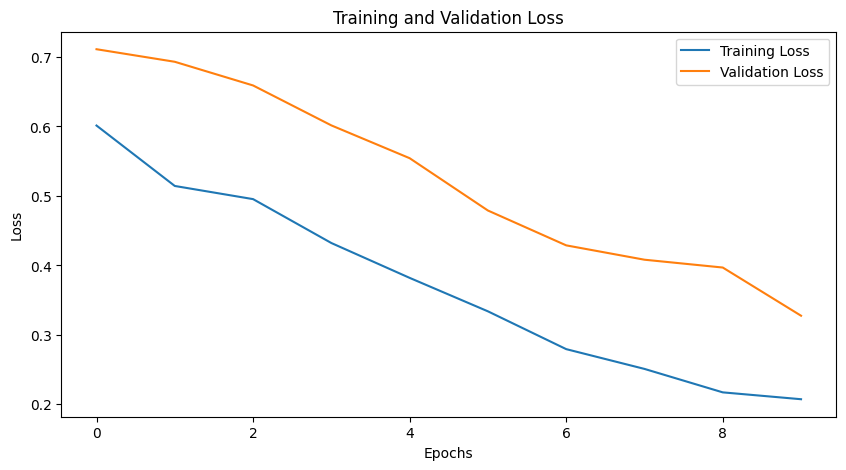

Finished Training


In [ ]:
torch.cuda.empty_cache()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
import matplotlib.pyplot as plt

# Define a simple warmup scheduler
def warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.
    return LambdaLR(optimizer, lr_lambda)

# Assuming SPACING() is your model and EarlyStopping is defined elsewhere
model = SPACING()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
warmup_steps = 10  # Number of steps for warmup
scheduler_warmup = warmup_scheduler(optimizer, warmup_steps)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

num_epochs = 10
early_stopping = EarlyStopping(patience=7, verbose=True)
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Update the learning rate during warmup
        if epoch * len(train_dataloader) + step < warmup_steps:
            scheduler_warmup.step()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(1), labels.float())
            val_loss += loss.item()

    val_loss /= len(test_dataloader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    # Update the learning rate based on the validation loss
    scheduler_plateau.step(val_loss)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Finished Training")

In [ ]:
import torch

# Save the model
model_path = './models/spacing_model.pth'
torch.save(model, model_path)
print("Model saved successfully at:", model_path)

# model = torch.load('./models/spacing_model.pth')

Model saved successfully at: ./models/spacing_model.pth


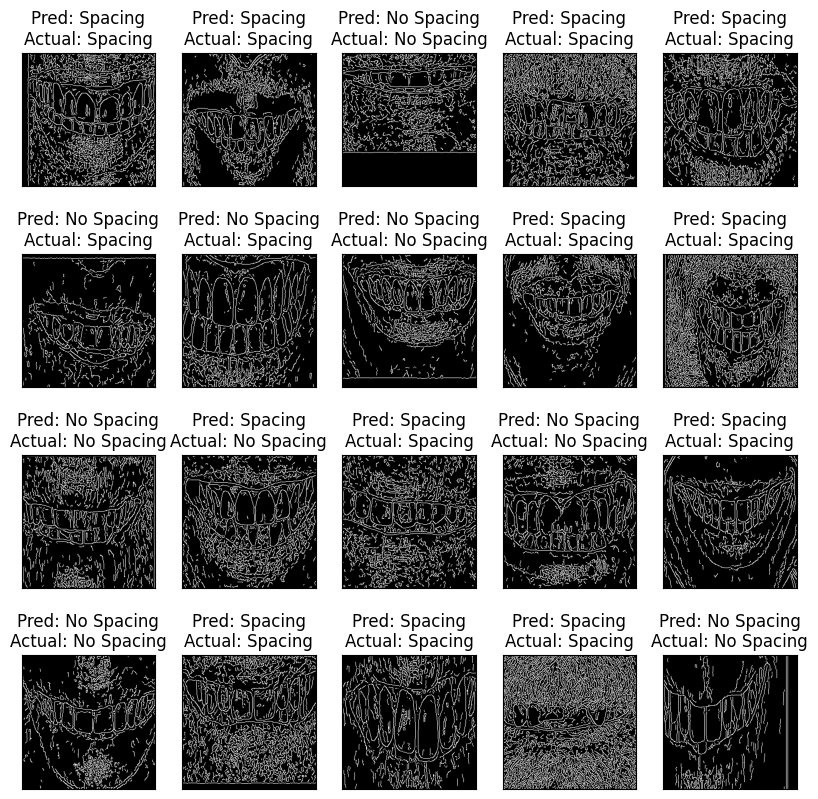

Test Accuracy: 85.25%


In [ ]:

def evaluate_and_show_images(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    # Set up matplotlib figure
    fig = plt.figure(figsize=(10, 10))
    image_count = 0  # Initialize a counter for displayed images

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).long()

            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

            # Plotting
            for j in range(images.size(0)):  # Iterate over images in the batch
                if image_count < 20:  # Display only 20 images
                    ax = fig.add_subplot(4, 5, image_count + 1, xticks=[], yticks=[])
                    if images.shape[1] == 1:  # Grayscale
                        img_to_display = images[j].cpu().squeeze().numpy()
                        cmap = 'gray'
                    else:  # RGB
                        img_to_display = images[j].cpu().permute(1, 2, 0).numpy()
                        cmap = None
                    plt.imshow(img_to_display, cmap=cmap)
                    ax.set_title(f"Pred: {'Spacing' if predicted[j].item() == 1 else 'No Spacing'}\n"
                                 f"Actual: {'Spacing' if labels[j].item() == 1 else 'No Spacing'}")
                    image_count += 1
                else:
                    break

    plt.show()
    accuracy = (100 * correct) / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Usage of the function
evaluate_and_show_images(model, test_dataloader)

tensor([[1.]], device='cuda:0')
Probabilities for lipline
Class 1: 1.0


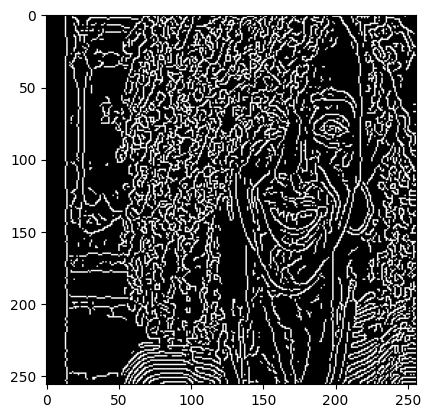

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Preprocess the image

image_path = 'test_imgs/girl-smile.webp'
image = Image.open(image_path).convert('RGB')
aug_img = augument_image(image)

# Set the model to evaluation mode
model.eval()

# Make a prediction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
aug_img = transforms.ToTensor()(aug_img)
with torch.no_grad():
    image_tensor = aug_img.unsqueeze(0).to(device)
    outputs = model(image_tensor)


# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(outputs, dim=1)
print(probabilities)
# Print the probabilities for all classes
print("Probabilities for lipline")
for i, prob in enumerate(probabilities[0]):
    print(f"Class {i+1}: {prob.item()}")


# show augmented image and moth crop next to each other
plt.imshow( aug_img.permute(1, 2, 0).numpy())